In [1]:
import os
import numpy as np
import networkx as nx

import process
import pandas

# Chip analysis

The following notebook is an analysis notebook. It has been conceived to order and analyse a dump of confocal images. All questions concerning the code should be emailed to gustave.ronteix@pasteur.fr.

These cells are to be used as fitting parameters for the cell

In [18]:
path = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS\4\5'

livePosition = 2
green = 0
orange = 1

channels = [livePosition, green, orange]

zRatio = 1/6
r = 10
d = 30
pxtoum = 1/3

dX = 2*(int(r/pxtoum)//2)+1
dY = 2*(int(r/pxtoum)//2)+1
dZ = 2*(int(zRatio*r/pxtoum)//2)+1

rNoyau = (dZ, dX, dY)

dX = 2*(int(d/pxtoum)//2)+1
dY = 2*(int(d/pxtoum)//2)+1
dZ = 2*(int(zRatio*d/pxtoum)//2)+1

dCells = (dZ, dX, dY)

minmass = 10000

In [5]:
import spheroid

Sph = spheroid.spheroid(path, '3', '5', zRatio, r, d,pxtoum, minmass)
    # Initialize spheroid

if len(channels) == 3: # Improve dependancy on channel number...

    Sph._loadImage(channels[0], 'NucImage') # Load live cells
    Sph._loadImage(channels[1], 'GreenImage') # Load green cells
    Sph._loadImage(channels[2], 'OrangeImage') # Load orange cells

else: print("Wrong number of color channels")

print('image made, starting nuclei ID')

image made, starting nuclei ID


In [6]:
from trackpy import preprocessing
import trackpy

df = trackpy.locate(Sph.NucImage[:,:,:], rNoyau, minmass=None, maxsize=None, separation=None, noise_size=1, 
                    smoothing_size=None, threshold=None, invert=False, percentile=64, topn=180, 
                    preprocess=True, max_iterations=10, filter_before=None, filter_after=None, characterize=True, 
                    engine='numba')

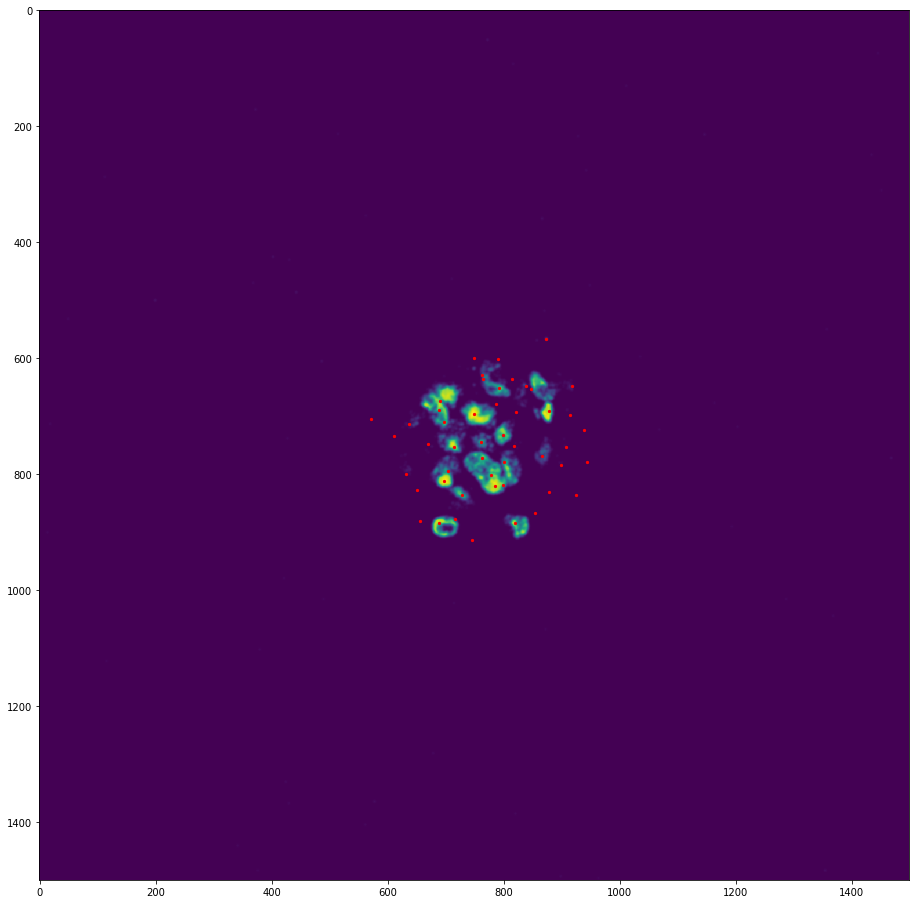

In [19]:
import matplotlib.pyplot as plt
from skimage import exposure
from scipy.ndimage import gaussian_filter

fd = df.loc[df['mass'] > minmass]

fd =fd.loc[((fd['x'] -fd['x'].mean())**2 < 4*fd['x'].std()**2) &
          ((fd['y'] -fd['y'].mean())**2 < 4*fd['y'].std()**2)]

img_eq = exposure.equalize_hist(Sph.NucImage[65,250:1750,250:1750])
im =  gaussian_filter(img_eq, sigma=2)

ax, fig = plt.subplots(figsize = (16,16))
plt.imshow(im)
plt.scatter(fd['x']-250, fd['y']-250, c = 'r', s = 5)

### Processing

The grunt functions are called from process.

Attention: verify the channel order.

In [20]:
path = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF BIS'
spheroidFolder = '3'
timeFolder = '5'

In [ ]:
process._sortFiles(path)

In [ ]:
process._makeSingleSpheroidClass(path, spheroidFolder, timeFolder, zRatio, rNoyau,
    dCells, pxtoum, channels, minmass)

prep image: 3 folder and time 5
image made, starting nuclei ID


Remarquons que la segmentation du spheroide dans un ou l'autre des types de cellules depend ici du classificateur naif que nous avons cree. Il repose sur un fit lineaire des points en fonction de leur couleur. On trouve que ce dernier doit avoir comme pente:

$a = \frac{<xy>}{<x^2>}$

Le signe par rapport a celui-ci est donne par:

$sign = y - a*x$

Ce qui nous donne par consequence un moyen rapide pour affecter un genre a chaque cellule.

In [ ]:
IntensityPath = r'\\atlas.pasteur.fr\Multicell\Gustave\fusionGustave\TIFF\Spheroids\\'

In [ ]:
df1 = pandas.read_csv(IntensityPath + 'intensityFrame_0_2.csv')

In [ ]:
import matplotlib.pyplot as plt

ax1 = df1.plot.scatter(x='Orange',y='Green', c= 'r')

In [ ]:
a = df1['Orange'].dot(df1['Green'])/(df1['Orange'].dot(df1['Orange']))

In [ ]:
ax1 = df1.plot.scatter(x='Orange',y='Green', c= 'r')
plt.plot(df1['Orange'], a*df1['Orange'])

In [ ]:
from sklearn import datasets
#Iris Dataset
iris = datasets.load_iris()
X = iris.data

In [ ]:
X = df1[['Orange', 'Green']]

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

#KMeans
km = KMeans(n_clusters=2)
km.fit(X)
km.predict(X)
labels = km.labels_

In [ ]:
df1['newLabels'] = labels

In [ ]:
df1

In [ ]:
from sklearn import mixture
gmm =  mixture.GaussianMixture(n_components=2).fit(X)
labels = gmm.predict(X)
fig, ax = plt.subplots(1, figsize=(7,7))
ax.scatter(X['Orange'], X['Green'],
          c=labels.astype(np.float), edgecolor="k", s=50)
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
plt.title("Gaussian Mixture", fontsize=14)

### Refined analysis

We use the refined metrics of networkx to add centrality, degree and other measures to the death/survival rates of the spheroid. The following process follows:

 - open json file
 - modify the spheroid properties
 - save global properties in soheroid file
 - save file

In [ ]:
def _refineSph(dic):
    
    G = _makeG(dic)
    
    A = networkx.betweenness_centrality(G) # betweeness centrality
    B = networkx.clustering(G)
    C = networkx.degree(G)
    
    for v in G:
        
        dic['cells'][v]['degree'] = C[v]
        dic['cells'][v]['clustering'] = B[v]
        dic['cells'][v]['centrality'] = A[v]
        
    dic['N'] = len(dic['cells'])
    dic['assortativity'] = nx.degree_assortativity_coefficient(G)
    dic['average degree'] = np.asarray([float(C[v]) for v in G]).mean()
    
    return dic

In [ ]:
_refineSph(_Sph)

process._saveSpheroid(_Sph.Spheroid, path + '\spheroid_' + spheroidFolder + r'_' +  timeFolder + '.json')